In [1]:
%reload_ext autoreload
%autoreload 2

In [5]:
problems = [
    ("Forrester", {})
]

methods = {
    "EI": "EI",
    "UCB": "UCB",
}

time_acqs = {
    "EI": False,
    "UCB": False,
    "EITimeRatio": True
}

acq_params = {
    "n_opt_samples": 1 * 1000,
    "n_opt_bfgs": 10
}

time_functions = [
    ("corrtime", "job-dependant")
]

max_steps = 200
num_runs = 21
workers = [4, 8, 16]

In [3]:

import botorch
import torch
import gpytorch
import numpy as np
from aegis.gen_training_data import generate_training_data_LHS
from aegis.optim import perform_optimisation

for problem_name, problem_params in problems:

    # Initial point generation
    generate_training_data_LHS(problem_name, n_exp_start=1, n_exp_end=num_runs)

    for time_name, interface in time_functions:

        for n_workers in workers:

            for acq_name in methods:

                time_acq = time_acqs[acq_name]

                for run in range(num_runs):

                    perform_optimisation(
                        problem_name=problem_name,
                        problem_params=problem_params,
                        run_no=run+1,
                        budget=max_steps,
                        n_workers=n_workers,
                        acq_name=acq_name,
                        acq_params=acq_params,
                        time_name=time_name,
                        save_every=10,
                        repeat_no=None,
                        interface='job-dependant',
                        time_acq=time_acq
                    )

/home/lewis/anaconda3/envs/mp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


File exists, skipping: data/Forrester_001.pt
File exists, skipping: data/Forrester_002.pt
File exists, skipping: data/Forrester_003.pt
File exists, skipping: data/Forrester_004.pt
File exists, skipping: data/Forrester_005.pt
File exists, skipping: data/Forrester_006.pt
File exists, skipping: data/Forrester_007.pt
File exists, skipping: data/Forrester_008.pt
File exists, skipping: data/Forrester_009.pt
File exists, skipping: data/Forrester_010.pt
File exists, skipping: data/Forrester_011.pt
File exists, skipping: data/Forrester_012.pt
File exists, skipping: data/Forrester_013.pt
File exists, skipping: data/Forrester_014.pt
File exists, skipping: data/Forrester_015.pt
File exists, skipping: data/Forrester_016.pt
File exists, skipping: data/Forrester_017.pt
File exists, skipping: data/Forrester_018.pt
File exists, skipping: data/Forrester_019.pt
File exists, skipping: data/Forrester_020.pt
File exists, skipping: data/Forrester_021.pt
Loading saved run
Training data shape: torch.Size([200,

/home/lewis/anaconda3/envs/mp/lib/python3.10/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Best found hyperparameters:
	Lengthscale: [0.00017402]
	Outputscale: 0.49989962577819824
Best found hyperparameters:
	Lengthscale: [0.09108923]
	Outputscale: 0.49990010261535645
SimExecutorJumpToCompletedJobProblemDependant.status:
{'n_free_workers': 4, 'n_busy_workers': 0, 'n_completed_tasks': 0, 'n_queue': 0, 't': 0, 'is_running': False}


RuntimeError: 

100%|██████████| 126/126 [00:00<00:00, 1101.59it/s]


KeyError: ('corrtime', 'job-dependant')

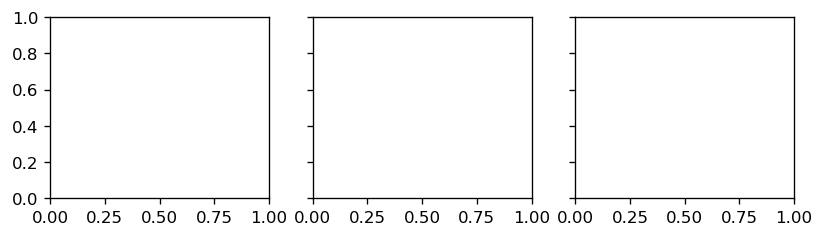

In [6]:
import aegis
from aegis import util
import numpy as np

D = aegis.plotting.read_in_results(
    [time_func for time_func, _ in time_functions], workers, problems, methods, num_runs, max_steps
)

TITLE_FONTSIZE = 16#19
LABEL_FONTSIZE = 15#18
TICK_FONTSIZE = 13#16

method_cols = (
    np.array(
        [
            [31, 119, 180],
            [255, 127, 14],
            [44, 160, 44],
            [214, 39, 40],
            [148, 103, 189],
            [227, 119, 194],
        ]
    )
    / 255
)

for time_func, interface in time_functions:
    aegis.plotting.make_conv_plots(
        D,
        time_func,
        problems,
        workers,
        max_steps,
        methods,
        method_cols,
        fname_prefix=None,
        TITLE_FONTSIZE=TITLE_FONTSIZE,
        LABEL_FONTSIZE=LABEL_FONTSIZE,
        TICK_FONTSIZE=TICK_FONTSIZE,
        savefig=False,
    )